In [1]:
# import gdown
# file_id = '17_boNLEhV6G0jwANXgjm6FClGLoMYmYI'
# output = 'blob'
# gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

In [2]:
# import zipfile
# zip_file_path = "blob"
# extract_to_directory = "extracted_files"
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_directory)
# print("Extraction complete.")

In [3]:
import time

def loading_time_calculator(dataloader):
    t1 = time.time()
    for data in dataloader:
        pass
    t2 = time.time()
    return t2 - t1

In [4]:
import csv
import numpy as np

class CustomDataset:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))
                dataset.append((image, label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

csv_train_path = 'extracted_files/mnist_train.csv'
csv_test_path = 'extracted_files/mnist_test.csv'
custom_dataset = CustomDataset(csv_train_path)
test_data_custom = CustomDataset(csv_test_path)

In [5]:
# Splitting the train dataset into train and validation datasets

from sklearn.model_selection import train_test_split
train_data_custom, val_data_custom = train_test_split(custom_dataset, test_size=0.1, random_state=42)


In [6]:
print("Total length of training set in csv file:",len(custom_dataset))

print("Length of training set after splitting:",len(train_data_custom))
print("Length of validation set after splitting:",len(val_data_custom))
print("Total length of test set in csv file:",len(test_data_custom))

# Access a sample from the dataset
sample_image, sample_label = custom_dataset[0]
print(f"Label: {sample_label}, Image Shape: {sample_image.shape}")

Total length of training set in csv file: 60000
Length of training set after splitting: 54000
Length of validation set after splitting: 6000
Total length of test set in csv file: 10000
Label: 5, Image Shape: (28, 28)


Now we will construct the custom dataloader from scratch

In [7]:
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.dataset[i] for i in batch_indices]

        self.current_index += self.batch_size

        images, labels = zip(*batch_data)
        return np.array(images), np.array(labels)


In [8]:
batch_sizes = [128, 256, 512, 1024]

In [9]:
# Getting loading times for Scratch Implementation for all batch sizes

custom_time=[]
for i in batch_sizes:
    custom_dataloader = CustomDataLoader(custom_dataset, i)
    duration = loading_time_calculator(custom_dataloader)
    custom_time.append(duration)

Now we will do the Pytorch Implementation

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TorchDataset(Dataset):
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))  # Assuming MNIST image dimensions are 28x28
                dataset.append((torch.tensor(image, dtype=torch.float32), label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        # Add channel dimension as torchvision expects (C, H, W)
        image = image.unsqueeze(0)
        return image, label

# Example usage
csv_file_path = 'extracted_files/mnist_train.csv'
torch_dataset = TorchDataset(csv_file_path)

transform = transforms.Compose([
    transforms.ToTensor()
])


In [11]:
# Getting loading times for Pytorch Implementation for all batch sizes

torch_time = []
for i in batch_sizes:
    torch_dataloader = DataLoader(dataset=torch_dataset, batch_size=i, shuffle=True)
    duration = loading_time_calculator(torch_dataloader)
    print(duration)
    torch_time.append(duration)

0.33119702339172363
0.2855081558227539
0.29902195930480957
0.2820751667022705


In [12]:
print("Loading Times obtained for Pytorch Implementation: ",torch_time)
print("Loading Times obtained for Scratch Implementation: ",custom_time)

Loading Times obtained for Pytorch Implementation:  [0.33119702339172363, 0.2855081558227539, 0.29902195930480957, 0.2820751667022705]
Loading Times obtained for Scratch Implementation:  [0.09888410568237305, 0.06250596046447754, 0.06249833106994629, 0.09374833106994629]


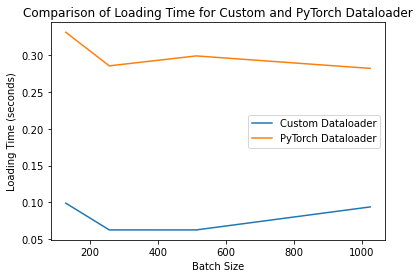

In [13]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

We can see from the above graphs that the Custom Dataloader takes less loading time than pytorch implementation. So for the next steps, we will choose the Custom dataset and dataloader having Batch Size- 512

Now we will Implement the Feed forward Neural Network using Pytorch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = FeedForwardNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)
num_epochs = 60

In [15]:
epoch_list=list(range(1, 61))

train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

Training the network and getting training, validation and test loss and accuracy

In [16]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)
    print()


    # Getting validation loss and accuracy
    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)
    print()

    # Getting test loss and accuracy
    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)
    

Epoch [1/60], Loss: 2.0358633995056152
Epoch 0, Accuracy on Training Set: 0.16914814814814816

Epoch [1/60], Validation Loss: 2.0942306518554688
Epoch 0, Accuracy on Validation Set: 0.22316666666666668

Epoch [1/60], Test Loss: 2.1175782680511475
Epoch 0, Accuracy on Test Set: 0.2395
Epoch [2/60], Loss: 1.8926206827163696
Epoch 1, Accuracy on Training Set: 0.31553703703703706

Epoch [2/60], Validation Loss: 1.8179291486740112
Epoch 1, Accuracy on Validation Set: 0.38283333333333336

Epoch [2/60], Test Loss: 1.7828701734542847
Epoch 1, Accuracy on Test Set: 0.3949
Epoch [3/60], Loss: 1.5132181644439697
Epoch 2, Accuracy on Training Set: 0.4572222222222222

Epoch [3/60], Validation Loss: 1.5997377634048462
Epoch 2, Accuracy on Validation Set: 0.49866666666666665

Epoch [3/60], Test Loss: 1.5383211374282837
Epoch 2, Accuracy on Test Set: 0.5115
Epoch [4/60], Loss: 1.2935030460357666
Epoch 3, Accuracy on Training Set: 0.5423148148148148

Epoch [4/60], Validation Loss: 1.3159295320510864
Ep

Plotting the training vs validation vs test loss

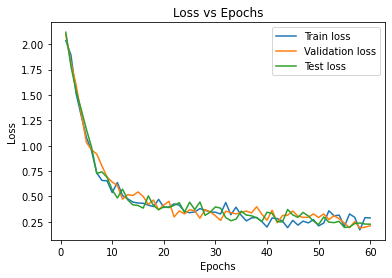

In [17]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

Plotting the training vs validation vs test accuracy

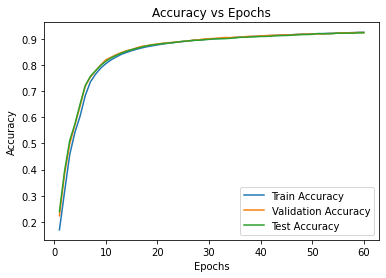

In [18]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Now we will construct the Feed forward Neural Network from Scratch.